[MSI:08658] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)


Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...
100.0 %        1.3e+05 s    Elapsed time so far: 64.0 s


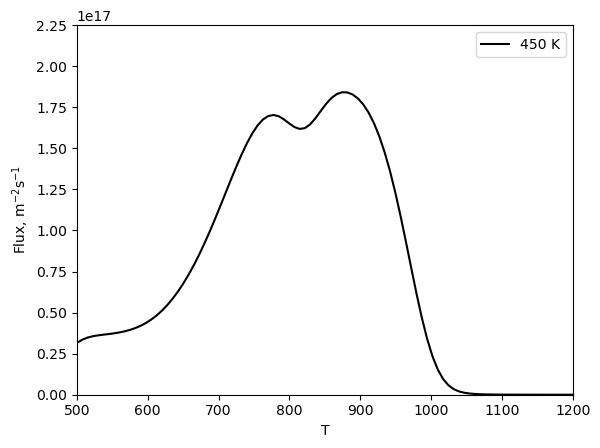

In [1]:
import festim as F
import fenics as f
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sympy as sp
import warnings

global n_surf

warnings.filterwarnings("ignore")

################### PARAMETERS ###################
# Exposure conditions
T_exposure = [450, 600, 800, 900, 1000]  # exposure temperature, K
t_exposure = 4 * 3600  # exposure time, s
Gamma_atom = 5.4e18  # the flux of D atoms, m-2 s-1
phi_W = 9.7e13  # the flux of W ions, m-2 s-1

T_storage = 300  # storage temperature, K
t_storage = 20000  # storage time?, s

T_stop_D = [
    420,
    490,
    610,
    690,
    750,
]  # temperature at which the D irradiation was stopped, K
dt_stop_D = 3 * 60  # time after which the D irradiation was stopped, s
T_add = 600  # temperature during additional exposure with D, K
t_add = 19 * 3600  # additional exposure time with D, s

cooling_rate = []
t_cool = []

for i in range(len(T_stop_D)):
    cooling_rate.append((T_exposure[i] - T_stop_D[i]) / dt_stop_D)  # cooling rate, K/s
    t_cool.append(
        (T_exposure[i] - T_storage) / cooling_rate[i]
    )  # cooling time after sequential exposure, K


ramp = 15 / 60  # K/s
T_TDS_max = 1323  # max temperature during TDS, K
t_TDS = (T_TDS_max - T_storage) / ramp  # s
t_heat_add = (T_add - T_storage) / ramp
# Sample
L = 0.8e-3  # half thickness, m

# W properties
rho_W = 6.3e28  # W atomic concentration, m^-3
n_IS = 6 * rho_W  # concentration of interstitial sites, m^-3
n_surf = 6.9 * rho_W ** (2 / 3)  # concentration of adsorption sites, m^-2

nu0 = 1e13  # attempt frequency, s^-1
SP = 0.19
D0 = 1.9e-7 / np.sqrt(2)  # diffusivity pre-factor, m^2 s^-1
E_diff = 0.2  # diffusion activation energy, eV
lambda_IS = 110e-12  # distance between 2 IS sites, m
sigma_exc = 1.7e-21  # Cross-section for the direct abstraction, m^2
lambda_des = 1 / n_surf ** (0.5)

# W self-damaged traps
Wdam_trap1_conc_max = [0.205e-2, 0.160e-2, 0.100e-2, 0.095e-2, 0.100e-2]
Wdam_trap2_conc_max = [0.110e-2, 0.085e-2, 0.080e-2, 0.065e-2, 0.060e-2]

distr = 1 / (1 + sp.exp((F.x - 1.2e-6) / 8.43e-8))
eta_i = 5e2 / 1.14e-6

Phi_i_W1 = [conc / eta_i * rho_W for conc in Wdam_trap1_conc_max]
Phi_i_W2 = [conc / eta_i * rho_W for conc in Wdam_trap2_conc_max]


# Transitions
E_bs = E_diff  # energy barrier from bulk to surface, eV
E_diss = 0  # energy barrier for D2 dissociation, eV
Q_sol = 1  # heat of solution, eV

################### MODEL ###################


def E_des(surf_conc):
    theta = surf_conc / n_surf
    return 0.525 + 0.591 / (1 + f.exp((theta - 0.247) / 0.0692))


def E_sb(surf_conc):
    theta = surf_conc / n_surf
    return 1.1 + 0.939 / (1 + f.exp((theta - 0.232) / 0.0683))


"""def E_sb(surf_conc):
    # energy barrier from surface to bulk, eV
    return (E_des(surf_conc) - E_diss) + E_bs + Q_sol"""


def K_sb(T, surf_conc, t):
    return nu0 * f.exp(-E_sb(surf_conc) / F.k_B / T)


def K_bs(T, surf_conc, t):
    return nu0 * f.exp(-E_bs / F.k_B / T)


for i in range(1):

    def J_vs(T, surf_conc, t):
        cond1 = f.conditional(t <= t_exposure + dt_stop_D, 1, 0)
        cond2 = f.conditional(
            t > t_exposure + t_cool[i] + t_storage,
            f.conditional(
                t <= t_exposure + t_cool[i] + t_storage + t_add + dt_stop_D, 1, 0
            ),
            0,
        )

        phi_atom = SP * Gamma_atom * (1 - surf_conc / n_surf) * (cond1 + cond2)

        phi_exc = Gamma_atom * sigma_exc * surf_conc * (cond1 + cond2)

        phi_des = (
            2
            * nu0
            * (lambda_des * surf_conc) ** 2
            * f.exp(-2 * E_des(surf_conc) / F.k_B / T)
        )
        return phi_atom - phi_exc - phi_des

    W_model = F.Simulation(log_level=40)

    # Mesh
    vertices = np.concatenate(
        [
            np.linspace(0, 2e-8, num=101),
            np.linspace(2e-8, 3e-6, num=200),
            np.linspace(3e-6, L, num=200),
        ]
    )

    W_model.mesh = F.MeshFromVertices(np.sort(vertices))

    # Materials
    tungsten = F.Material(id=1, D_0=D0, E_D=E_diff)
    W_model.materials = tungsten

    damaged_density1 = (
        Wdam_trap1_conc_max[i]
        * rho_W
        * distr
        * sp.Piecewise(
            (1 - sp.exp(-(F.t * phi_W / Phi_i_W1[i])), F.t <= t_exposure),
            (1 - sp.exp(-(t_exposure * phi_W / Phi_i_W1[i])), True),
        )
    )
    damaged_density2 = (
        Wdam_trap2_conc_max[i]
        * rho_W
        * distr
        * sp.Piecewise(
            (1 - sp.exp(-(F.t * phi_W / Phi_i_W2[i])), F.t <= t_exposure),
            (1 - sp.exp(-(t_exposure * phi_W / Phi_i_W2[i])), True),
        )
    )
    traps = F.Traps(
        [
            F.Trap(
                k_0=D0 / (n_IS * lambda_IS**2),
                E_k=E_diff,
                p_0=nu0,
                E_p=0.85,
                density=1e-4 * rho_W,
                materials=tungsten,
            ),
            F.Trap(
                k_0=D0 / (n_IS * lambda_IS**2),
                E_k=E_diff,
                p_0=nu0,
                E_p=1.00,
                density=1e-4 * rho_W,
                materials=tungsten,
            ),
            F.Trap(
                k_0=D0 / (n_IS * lambda_IS**2),
                E_k=E_diff,
                p_0=nu0,
                E_p=1.83,
                density=damaged_density1,
                materials=tungsten,
            ),
            F.Trap(
                k_0=D0 / (n_IS * lambda_IS**2),
                E_k=E_diff,
                p_0=nu0,
                E_p=2.10,
                density=damaged_density2,
                materials=tungsten,
            ),
        ]
    )
    W_model.traps = traps

    W_model.T = F.Temperature(
        value=sp.Piecewise(
            (T_exposure[i], F.t <= t_exposure),
            (
                T_exposure[i] - cooling_rate[i] * (F.t - t_exposure),
                F.t <= t_exposure + t_cool[i],
            ),
            (T_storage, F.t <= t_exposure + t_cool[i] + t_storage),
            (T_add, F.t <= t_exposure + t_cool[i] + t_storage + t_add),
            (
                T_add
                - cooling_rate[1] * (F.t - t_exposure - t_cool[i] - t_storage - t_add),
                F.t <= t_exposure + t_cool[i] + t_storage + t_add + t_cool[1],
            ),
            (
                T_storage,
                F.t <= t_exposure + t_cool[i] + 2 * t_storage + t_add + t_cool[1],
            ),
            (
                T_storage
                + ramp
                * (F.t - t_exposure - t_cool[i] - 2 * t_storage - t_add - t_cool[1]),
                True,
            ),
        )
    )

    my_BC = F.SurfaceKinetics(
        k_sb=K_sb,
        k_bs=K_bs,
        lambda_IS=lambda_IS,
        n_surf=n_surf,
        n_IS=n_IS,
        J_vs=J_vs,
        surfaces=[1, 2],
        initial_condition=0,
        t=F.t,
    )

    W_model.boundary_conditions = [my_BC]

    def dt(t):
        if t < t_exposure:
            return 100
        elif (
            t > t_exposure + t_cool[i] + t_storage
            and t < t_exposure + t_cool[i] + t_storage + t_add
        ):
            return 100
        elif t > t_exposure + t_cool[i] + t_cool[1] + t_add + 2 * t_storage:
            return 30
        else:
            return 200

    W_model.dt = F.Stepsize(
        initial_value=1e-4,
        stepsize_change_ratio=1.1,
        max_stepsize=dt,
        dt_min=1e-6,
        milestones=[
            t_exposure,
            t_exposure+t_cool[i],
            t_exposure+t_cool[i]+t_storage,
            t_exposure+t_cool[i]+t_storage+t_add,
            t_exposure+t_cool[i]+t_storage+t_add+t_cool[1],
            t_exposure+t_cool[i]+2*t_storage+t_add+t_cool[1],
            t_exposure+t_cool[i]+2*t_storage+t_add+t_cool[1]+t_TDS,
        ]
    )

    W_model.settings = F.Settings(
        absolute_tolerance=1e10,
        relative_tolerance=1e-8,
        maximum_iterations=50,
        final_time=t_exposure
        + t_cool[i]
        + 2 * t_storage
        + t_heat_add
        + t_add
        + t_cool[1]+
        t_TDS
    )

    # Exports
    results_folder = "./results/"

    derived_quantities = F.DerivedQuantities(
        [
            F.AdsorbedHydrogen(surface=1),
            F.AdsorbedHydrogen(surface=2),
            F.TotalVolume(field="retention", volume=1),
            F.TotalVolume(field="1", volume=1),
            F.TotalVolume(field="2", volume=1),
            F.TotalVolume(field="3", volume=1),
            F.TotalVolume(field="4", volume=1),
            F.TotalSurface(field="T", surface=1),
        ],
        nb_iterations_between_compute=1,
        filename=results_folder + "test.csv",
    )

    W_model.exports = [derived_quantities]

    W_model.initialise()
    W_model.run()

    results = pd.read_csv(results_folder + "test.csv", header=0)

    results["Flux1"] = results["Adsorbed H on surface 1"]
    for j in range(len(results)):
        surf_conc1 = results["Adsorbed H on surface 1"][j]
        surf_conc2 = results["Adsorbed H on surface 2"][j]
        T = results["Total T surface 1"][j]

        results["Flux1"][j] = (
            2
            * nu0
            * (lambda_des * surf_conc1) ** 2
            * f.exp(-2 * E_des(surf_conc1) / F.k_B / T)
        ) + (
            2
            * nu0
            * (lambda_des * surf_conc2) ** 2
            * f.exp(-2 * E_des(surf_conc2) / F.k_B / T)
        )

    plt.plot(T_storage + ramp * (results["t(s)"]-(t_exposure+t_cool[i]+2*t_storage+t_add+t_cool[1])),  
             results["Flux1"],label = f'450 K', color = 'black')
    #plt.plot(results["t(s)"],  results["Total retention volume 1"],label = f'1')
    # plt.plot(results["t(s)"],  results["Total 2 volume 1"],label = f'2')
    # plt.plot(results["t(s)"],  results["Total 3 volume 1"],label = f'3')
    # plt.plot(results["t(s)"],  results["Total 4 volume 1"],label = f'4')
    plt.legend()
    plt.xlim(500,1200)
    plt.ylim(0, 2.25e17)
    plt.ylabel(r"Flux, m$^{-2}$s$^{-1}$")
    plt.xlabel(r"T")

plt.show()